In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [4]:
X, y = make_regression(n_samples=1000,n_features=100,n_informative=10, noise=0.1, random_state=1)
(X.shape, y.shape)

((1000, 100), (1000,))

In [30]:
X

array([[ 0.30893705, -1.35811724,  1.79967284, ..., -0.55219994,
        -1.50804141,  0.14923664],
       [-0.71467683, -0.9113987 ,  0.70454252, ..., -0.77040112,
         0.4975401 ,  0.83628731],
       [-2.41427283,  0.27041568, -1.89020704, ...,  0.43497414,
         0.96762308,  1.10718341],
       ...,
       [ 0.87044468,  0.31139596,  0.59143176, ..., -0.03046589,
        -0.39953994, -1.17687347],
       [-0.07522565, -1.92262426,  0.69964754, ..., -0.59371794,
         0.07702001, -0.94298857],
       [-0.10375714,  1.32088598,  1.09781828, ..., -0.41184483,
         0.10809159, -1.00706195]])

I wont rewrite the text fields that explain each step, you can go back to autoencoder for classification to understand more




In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=1)
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train) 
X_test = t.transform(X_test)

We will define the encoder to have one hidden layer with the same(or *2?) number of nodes as there are in the input data with batch normalization and ReLU activation.

This is followed by a bottleneck layer with the same number of nodes as columns in the input data, e.g. no compression.

In [25]:
# encoder
# hidden layer
n_inputs = 100
visible = Input(shape=(n_inputs), name='input1')
e = Dense(n_inputs*2, name='dense1')(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# bottleneck layer
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck, name='bottleneck1')(e)

The decoder will be defined with the same structure.

It will have one hidden layer with batch normalization and ReLU activation. The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

In [26]:
# define decoder
d = Dense(n_inputs*2, name='dense2')(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, name='dense3', activation='linear')(d) # to get continuous values in the output

In [27]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

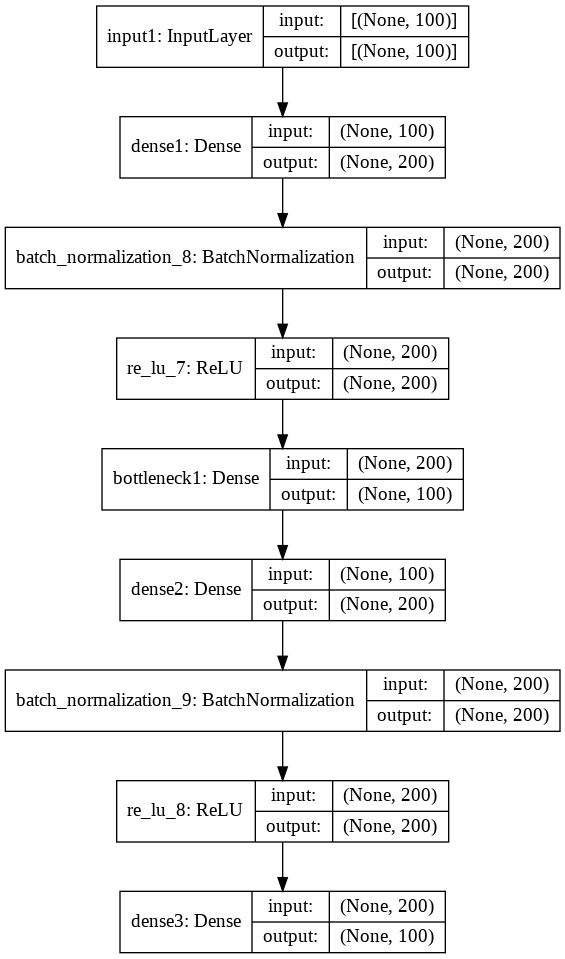

In [28]:
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)

In [14]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/400
42/42 - 1s - loss: 0.3629 - val_loss: 0.1927
Epoch 2/400
42/42 - 0s - loss: 0.1400 - val_loss: 0.1527
Epoch 3/400
42/42 - 0s - loss: 0.0970 - val_loss: 0.1147
Epoch 4/400
42/42 - 0s - loss: 0.0769 - val_loss: 0.0877
Epoch 5/400
42/42 - 0s - loss: 0.0641 - val_loss: 0.0701
Epoch 6/400
42/42 - 0s - loss: 0.0547 - val_loss: 0.0608
Epoch 7/400
42/42 - 0s - loss: 0.0474 - val_loss: 0.0528
Epoch 8/400
42/42 - 0s - loss: 0.0425 - val_loss: 0.0487
Epoch 9/400
42/42 - 0s - loss: 0.0382 - val_loss: 0.0461
Epoch 10/400
42/42 - 0s - loss: 0.0350 - val_loss: 0.0443
Epoch 11/400
42/42 - 0s - loss: 0.0323 - val_loss: 0.0423
Epoch 12/400
42/42 - 0s - loss: 0.0297 - val_loss: 0.0411
Epoch 13/400
42/42 - 0s - loss: 0.0281 - val_loss: 0.0396
Epoch 14/400
42/42 - 0s - loss: 0.0265 - val_loss: 0.0379
Epoch 15/400
42/42 - 0s - loss: 0.0254 - val_loss: 0.0378
Epoch 16/400
42/42 - 0s - loss: 0.0239 - val_loss: 0.0369
Epoch 17/400
42/42 - 0s - loss: 0.0231 - val_loss: 0.0357
Epoch 18/400
42/42 - 0s

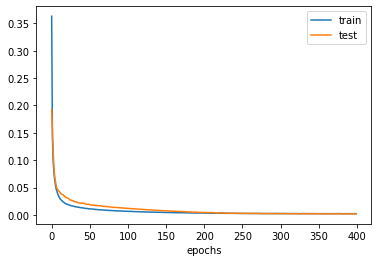

In [16]:
#After training, we can plot the learning curves for the train and test sets to confirm the model learned the reconstruction problem well.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("epochs")
plt.legend()
plt.show()

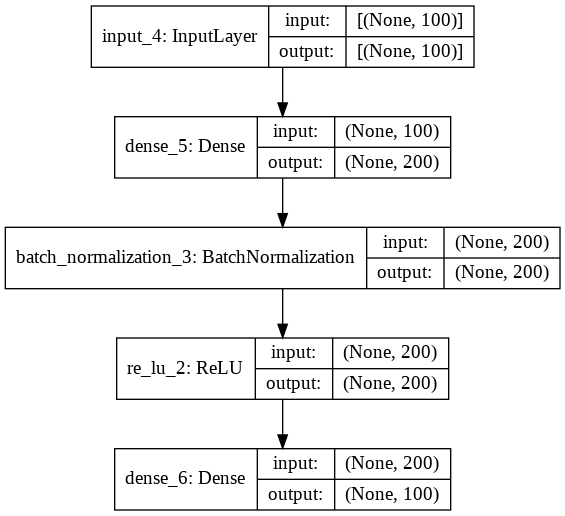

In [18]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)

In [19]:
# So far, so good. We know how to develop an autoencoder without compression.
# save the encoder to file
encoder.save('encoder.h5')

# ***Autoencoder as Data Preparation***

In this section, we will use the trained encoder model from the autoencoder model to compress input data and train a different predictive model.

First, let’s establish a baseline in performance on this problem. This is important as if the performance of a model is not improved by the compressed encoding, then the compressed encoding does not add value to the project and should not be used.

We can train a support vector regression (SVR) model on the training dataset directly and evaluate the performance of the model on the holdout test set.

As is good practice, we will scale both the input variables and target variable prior to fitting and evaluating the model.







---



In [32]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
X, y = make_regression(n_samples=1000,n_features=100,n_informative=10, noise=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# reshape target variables so that we can transform them
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))
# scale input data
t1 = MinMaxScaler()
t1.fit(X_train)
X_train = t1.transform(X_train)
X_test = t1.transform(X_test)
# scale output data
t2 = MinMaxScaler()
t2.fit(y_train)
y_train = t2.transform(y_train)
y_test = t2.transform(y_test)

In [35]:
# define model
model_svr = SVR()
# fit model on the training dataset
model_svr.fit(X_train, y_train)
# make prediction on test set
y_pred = model_svr.predict(X_test)
# invert transforms so we can calculate errors
y_pred = y_pred.reshape((len(y_pred), 1))
y_pred = t2.inverse_transform(y_pred)
y_test = t2.inverse_transform(y_test)
# calculate error
score = mean_absolute_error(y_test, y_pred)
print(score)

89.51082036130629


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running the example fits an SVR model on the training dataset and evaluates it on the test set.
In this case, we can see that the model achieves a mean absolute error (MAE) of about 89.

We would hope and expect that a SVR model fit on an encoded version of the input to achieve lower error for the encoding to be considered useful.

We can update the example to first encode the data using the encoder model trained in the previous section.

In [36]:
# load the model from file
from  tensorflow.keras.models import load_model 
encoder = load_model('encoder.h5')

We can then use the encoder to transform the raw input data (e.g. 100 columns) into bottleneck vectors (e.g. 100 element vectors).

This process can be applied to the train and test datasets.

In [37]:
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

In [42]:
# define model
model_svr = SVR()
# fit model on the training dataset
model_svr.fit(X_train_encode, y_train)
# make prediction on test set
y_pred = model.predict(X_test_encode)
# invert transforms so we can calculate errors
y_pred = y_pred.reshape((len(y_pred), 1))
y_pred = t2.inverse_transform(y_pred)
y_test = t2.inverse_transform(y_test)
# calculate error

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
score = mean_absolute_error(y_test, y_pred)
print(score)
# NORMALEMENT LE RESULTAT EST  69.45890939600503, in this case, we can see that the model achieves a MAE of about 69.

# This is a better MAE than the same model evaluated on the raw dataset, suggesting that the encoding is helpful for our chosen model and test harness

306281139533.53186
